# Clustering

||| stands next to the header of those where I think so far, they don't give us information or no new valuable information. So probably delete later.

## Preparation

In [75]:
#import csv
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
import matplotlib.dates as mdates
import seaborn as sns
from pandas.api.types import CategoricalDtype

#clustering
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D

import warnings;
warnings.filterwarnings('ignore');

In [2]:
#reading in data and prepare for Frankfurt 2015 and 2016
#just clustering on both years, no separate clustering since it does not seem useful

We are going to cluster the stations first. Station names and IDs would just appear as index, hence data points in a cluster, still they would be added together for all NaN in one cluster. We do not know what NaN means for certain stations. Did it mean that the station simply wasn't added to the data or that the bike isn't at a specific station? Since we cannot know this for sure, we will drop all the rows with NaN values.

In [3]:
# 1. read data
# 2. drop NaN values
# 3. split for Frankfurt
# 4. split for right timing
# 5. change other date formats 
# 6. add duration column
booking_set = pd.read_csv("OPENDATA_BOOKING_CALL_A_BIKE.csv", delimiter=';')
booking_set = booking_set.dropna()

In [4]:
booking_set_frankfurt = booking_set[booking_set['CITY_RENTAL_ZONE'].str.contains('Frankfurt')]

In [5]:
booking_set_frankfurt.sort_values(['DATE_BOOKING'], axis=0, 
                 ascending=True, inplace=True) #sort the data after the date, ascending
booking_set_frankfurt['DATE_BOOKING'] = pd.to_datetime(booking_set_frankfurt['DATE_BOOKING'])
booking_set_frankfurt['DATE_BOOKING'].dt.strftime('%Y-%m-%d %X')
start_date_20152016 = '2015-01-01 00:00:00'
end_date_20152016 = '2016-12-31 23:59:59'
filtered_dates_20152016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_20152016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_20152016)
booking_set_frankfurt_20152016 = booking_set_frankfurt.loc[filtered_dates_20152016]

In [6]:
booking_set_frankfurt_20152016['DATE_UNTIL'] = pd.to_datetime(booking_set_frankfurt_20152016['DATE_UNTIL'])
booking_set_frankfurt_20152016['DATE_UNTIL'].dt.strftime('%Y-%m-%d %X')
booking_set_frankfurt_20152016['DATE_FROM'] = pd.to_datetime(booking_set_frankfurt_20152016['DATE_FROM'])
booking_set_frankfurt_20152016['DATE_FROM'].dt.strftime('%Y-%m-%d %X')
booking_set_frankfurt_20152016['duration'] = booking_set_frankfurt_20152016['DATE_UNTIL'] - booking_set_frankfurt_20152016['DATE_FROM']


## Cluster stations by amount of bookings and amount of vehicles |||

### Preparation

In [138]:
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'VEHICLE_HAL_ID']]

In [139]:
first_cluster = cluster.groupby('START_RENTAL_ZONE_HAL_ID', as_index = False)['VEHICLE_HAL_ID', 'BOOKING_HAL_ID'].count()

In [140]:
first_cluster = first_cluster.set_index('START_RENTAL_ZONE_HAL_ID')

In [141]:
first_cluster

,VEHICLE_HAL_ID,BOOKING_HAL_ID
START_RENTAL_ZONE_HAL_ID,,
3710.0,2017,2017
3717.0,810,810
3916.0,4051,4051
3954.0,2030,2030
3961.0,9125,9125
...,...,...
258996.0,344,344
258998.0,182,182
258999.0,78,78


### K-Means

In [49]:
#scale values
scaler = StandardScaler()
scaler.fit(first_cluster)
X_scaled = scaler.transform(first_cluster)
X_scaled_df = pd.DataFrame(X_scaled, columns=first_cluster.columns, index=first_cluster.index)
X_scaled_df.head()

,VEHICLE_HAL_ID,BOOKING_HAL_ID
START_RENTAL_ZONE_HAL_ID,,
3710.0,-0.245497,-0.245497
3717.0,-0.478362,-0.478362
3916.0,0.146920,0.146920
3954.0,-0.242989,-0.242989
3961.0,1.125840,1.125840


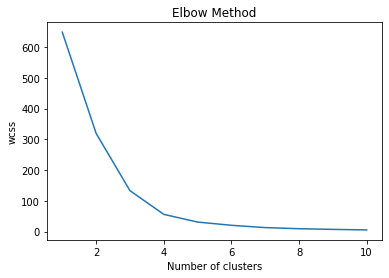

In [50]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

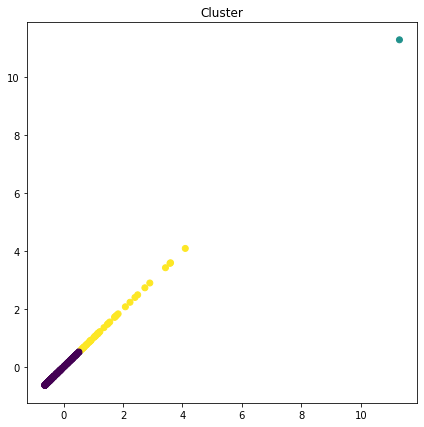

In [51]:
#plot the k-means
means = KMeans(n_clusters=3, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Cluster")

plt.show()

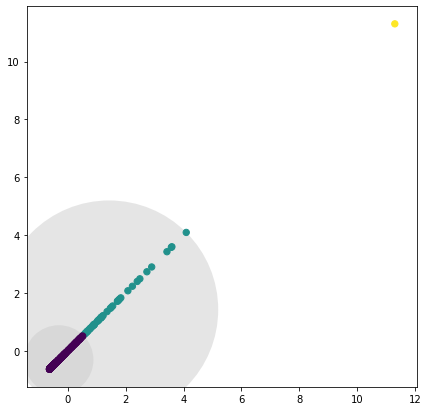

In [53]:
plt.figure(figsize = (7,7))
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
plot_kmeans(means, X_scaled)

### Gaussian Mixture

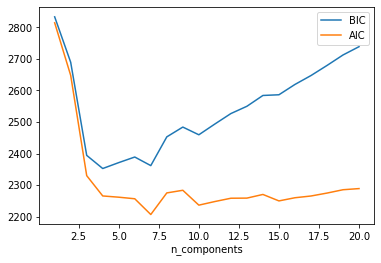

In [54]:
#The optimal number of clusters is the value that minimizes the AIC or BIC
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(first_cluster)
          for n in n_components]

plt.plot(n_components, [m.bic(first_cluster) for m in models], label='BIC')
plt.plot(n_components, [m.aic(first_cluster) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

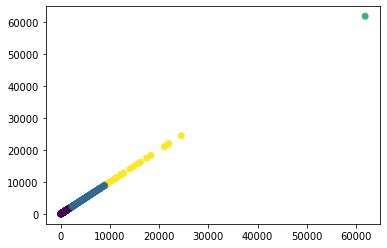

In [55]:
gmm = GaussianMixture(n_components=4).fit(first_cluster)
labels = gmm.predict(first_cluster)
plt.scatter(first_cluster['BOOKING_HAL_ID'], first_cluster['VEHICLE_HAL_ID'], c=labels, cmap='viridis')

### Hierarchical Clustering

It should be noted that hierarchical clustering isn't working very well with large datasets. Hence, we might have to split the data sotimes. Can we consider this splitted still be representable of the original data set? For the sake of trying HC, we will still perform a cluster. However, if we have to split a lot, we might drop it.  

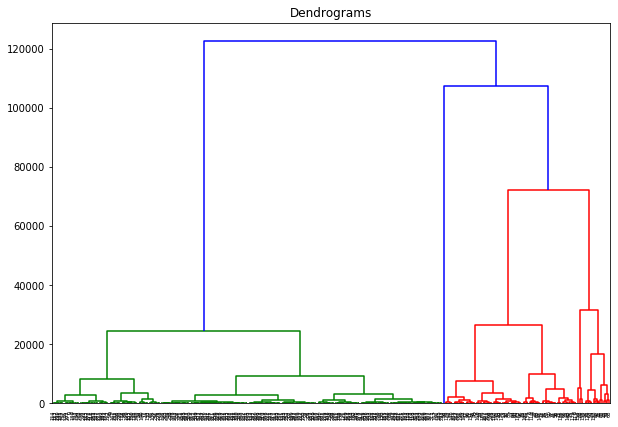

In [56]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(first_cluster, method='ward'))

The longest vertical aline without any horizonal line is going to be drawn through by a red line. It represents a threshold, the minimum distance required to be a separate cluster. In our case, it is the blue line. The new red line is going through 4 horizontal lines, so we build 4 clusters.

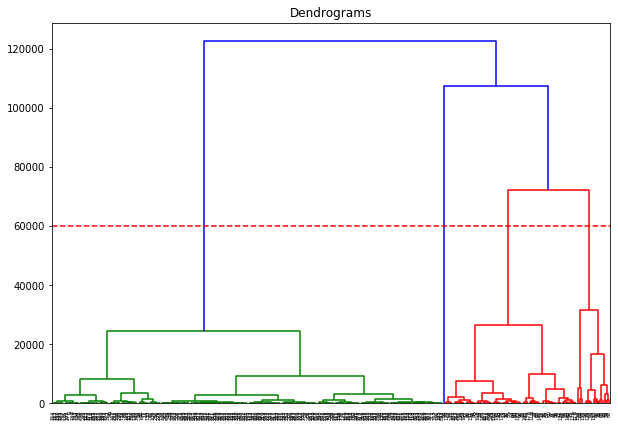

In [143]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(first_cluster, method='ward'))
plt.axhline(y=60000, color='r', linestyle='--')

#### Euclidian distance with ward linkage

In [58]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(first_cluster)

array([3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1,
       3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 0, 3, 3, 1, 3, 0, 3, 0, 0, 1, 1, 1,
       0, 0, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 2, 3, 3, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 3, 1, 3, 0, 1, 3, 3, 1, 1, 1, 3,
       3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 0, 3, 3, 1, 3, 3,
       3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3,
       3, 3, 0, 0, 0, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

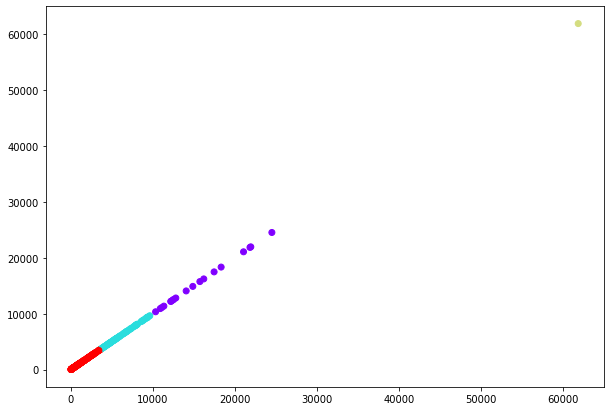

In [59]:
plt.figure(figsize=(10, 7))
plt.scatter(first_cluster['BOOKING_HAL_ID'], first_cluster['VEHICLE_HAL_ID'], c=cluster.labels_, cmap='rainbow')

#### Manhattan distance with average linkage

In [60]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='manhattan', linkage='average')  
cluster.fit_predict(first_cluster)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 2,
       0, 0, 2, 1, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

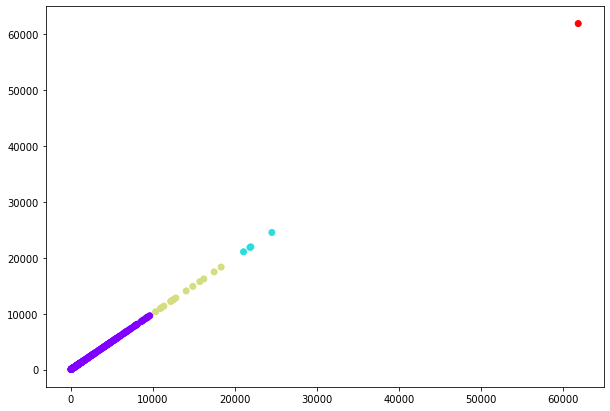

In [61]:
plt.figure(figsize=(10, 7))
plt.scatter(first_cluster['BOOKING_HAL_ID'], first_cluster['VEHICLE_HAL_ID'], c=cluster.labels_, cmap='rainbow')

### Result: 
The linear relationship was to be expected since each booking comes automatically with a vehicle. Cloud forms wouldn't have been possible, except for zero values or multiple ids for one booking. So there is always the same amount of bookings and vehicles.
Still, you can see that there are more stations with 'a few' bookings and vehicles with the threshold 10000. After that the clusters get more sparse. Up to 20000 is the next. Over 20000 are even less and then there apparently just one station that is far bigger than all the others, with 60000. Other models represented these clusters with smaller amounts, hence once cluster until 5000, one cluster until roughly 12000 and then one very sparse cluster till 30000. The one cluster with 60000 is always separated from the others though. 

### Possible Explanation: 

The most used station is probably the main train station, which is as we have seen in the descriptive analysis the most used one. The other ones are most probably located right around this center, with the less used stations the farthest away from the center. 

## Cluster stations by customer types

### Preparation

In [95]:
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'CUSTOMER_HAL_ID']]

In [113]:
a = cluster.groupby(['START_RENTAL_ZONE_HAL_ID', 'CUSTOMER_HAL_ID'], as_index = False)['BOOKING_HAL_ID'].count()

In [114]:
a

,START_RENTAL_ZONE_HAL_ID,CUSTOMER_HAL_ID,BOOKING_HAL_ID
0,3710.0,0038B6A6E05D3CF8B0C6037CE4E3C692AE9F178B,1
1,3710.0,0049D2D3AA87A52C549BA4D85A2B954CA6CC99EF,2
2,3710.0,0052156FB7E0171B04D3C50C89083A6B148BB28B,4
3,3710.0,01B068158C16C44196CE6011C95B648CE282AD9E,1
4,3710.0,01E9FDA01F033E74892FF6987C71AEB1C248BC50,1
...,...,...,...
280129,259001.0,983240171DEEDE1F16E1A036E9C674CD006DFFD1,11
280130,259001.0,9B7CD570A38733693CF2A97EC076DB4C7DA36D72,1
280131,259001.0,9F9BD8A111C54FD69B4AA623F7D3BF85CE1E797A,1
280132,259001.0,FA935580BC08EA1521D971ABDDE3C0218F7A3551,1


In [119]:
a2 = cluster.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False).agg({'CUSTOMER_HAL_ID': pd.Series.nunique})
a2

,START_RENTAL_ZONE_HAL_ID,CUSTOMER_HAL_ID
0,3710.0,468
1,3717.0,211
2,3916.0,1443
3,3954.0,938
4,3961.0,3807
...,...,...
319,258996.0,91
320,258998.0,81
321,258999.0,36
322,259000.0,23


In [120]:
b = a.loc[a['BOOKING_HAL_ID'] > 300]
b

,START_RENTAL_ZONE_HAL_ID,CUSTOMER_HAL_ID,BOOKING_HAL_ID
1363,3916.0,78099BA3106E23000A8F789BB0F9DD51260AACE4,307
10042,6723.0,1E0EF9ED3BFF806B03EDD3430BEF6832B98605CF,307
19838,20098.0,8A9C7E8EF877F68DDB4A2EE654B0B08A776AEFA2,493
37990,31166.0,9EDD7B3EF01849AE762E3F1CDC9D381631453B7C,332
41049,43880.0,F8A9E7CD2FE7B1675BB2DADF1C7FCCCFDB70D67E,363
87565,214394.0,576479090C0CE83320C0FF22400C938DAD1DF677,595
98390,214417.0,8EDE3D7ECCC0638E2148B25705A16467B21B3EDF,493
101188,214419.0,2F6947AECF5E4454E95E3D694FB4677B9959BEFF,343
113514,214444.0,F3EF5F487569C78BB2E1B3101C1E223DF9270AB9,309
114914,214446.0,204E420C56F7860BF2B5742ED19453DA2339AC08,309


In [121]:
b2 = b.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False).agg({'CUSTOMER_HAL_ID': pd.Series.nunique})
b2

,START_RENTAL_ZONE_HAL_ID,CUSTOMER_HAL_ID
0,3916.0,1
1,6723.0,1
2,20098.0,1
3,31166.0,1
4,43880.0,1
5,214394.0,1
6,214417.0,1
7,214419.0,1
8,214444.0,1
9,214446.0,1


In [122]:
c = a.loc[a['BOOKING_HAL_ID'] > 100]
c

,START_RENTAL_ZONE_HAL_ID,CUSTOMER_HAL_ID,BOOKING_HAL_ID
160,3710.0,61B930C90852E7BCEFC84FFE2B82901F60EBB2E0,166
1363,3916.0,78099BA3106E23000A8F789BB0F9DD51260AACE4,307
2746,3954.0,A45443A82B34D2B95DA0D6A9C9A78CB39808FCE2,225
10031,6723.0,1A310E94E49DA71D3BDBFB3677DE45304969B350,159
10042,6723.0,1E0EF9ED3BFF806B03EDD3430BEF6832B98605CF,307
...,...,...,...
266842,254291.0,A0D4EF5CE36D3A61B047A3205C473015F5E21F6E,102
266882,254291.0,D9F4F94F2CE21FD6DE20DF1B5D22C594898D89AF,158
270766,254307.0,696253DB3EE172688F1901701AECAF5B340481CD,226
270844,254307.0,B6AFE2A3C1BD374058E92A09923A9C95370A5E42,133


In [124]:
c2 = c.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False).agg({'CUSTOMER_HAL_ID': pd.Series.nunique})
c2 = c2.rename(columns={"CUSTOMER_HAL_ID" : "over_100_bookings"})

In [126]:
a2 = a2.set_index('START_RENTAL_ZONE_HAL_ID')
c2 = c2.set_index('START_RENTAL_ZONE_HAL_ID')

In [127]:
a2

,CUSTOMER_HAL_ID
START_RENTAL_ZONE_HAL_ID,
3710.0,468
3717.0,211
3916.0,1443
3954.0,938
3961.0,3807
...,...
258996.0,91
258998.0,81
258999.0,36


In [128]:
c2

,over_100_bookings
START_RENTAL_ZONE_HAL_ID,
3710.0,1
3916.0,1
3954.0,1
6723.0,12
7596.0,5
...,...
254285.0,2
254288.0,1
254291.0,2


In [133]:
result = pd.concat([a2, c2], axis=1)
result.fillna(0, inplace=True)

In [134]:
result

,CUSTOMER_HAL_ID,over_100_bookings
START_RENTAL_ZONE_HAL_ID,,
3710.0,468,1.0
3717.0,211,0.0
3916.0,1443,1.0
3954.0,938,1.0
3961.0,3807,0.0
...,...,...
258996.0,91,0.0
258998.0,81,0.0
258999.0,36,0.0


### K-Means

In [135]:
#scale values
scaler = StandardScaler()
scaler.fit(result)
X_scaled = scaler.transform(result)
X_scaled_df = pd.DataFrame(X_scaled, columns=result.columns, index=result.index)
X_scaled_df.head()

,CUSTOMER_HAL_ID,over_100_bookings
START_RENTAL_ZONE_HAL_ID,,
3710.0,-0.333693,-0.208075
3717.0,-0.549923,-0.382276
3916.0,0.486634,-0.208075
3954.0,0.061747,-0.208075
3961.0,2.475613,-0.382276


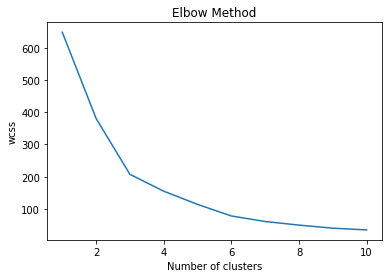

In [136]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

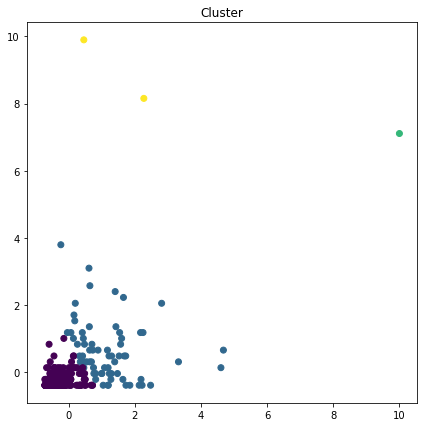

In [138]:
#plot the k-means
means = KMeans(n_clusters=4, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Cluster")

plt.show()

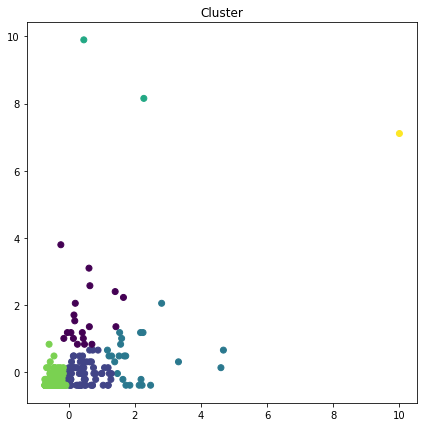

In [167]:
#plot the k-means
means = KMeans(n_clusters=6, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Cluster")

plt.show()

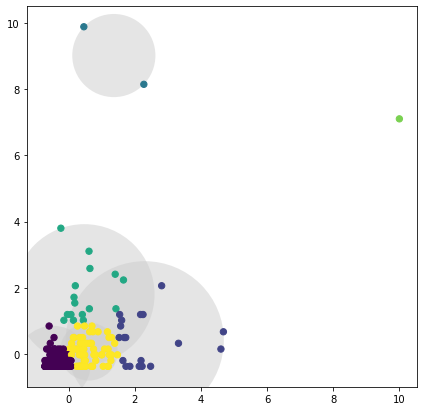

In [168]:
plt.figure(figsize = (7,7))
def plot_kmeans(kmeans, X, n_clusters=6, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
plot_kmeans(means, X_scaled)

### Gaussian Mixture

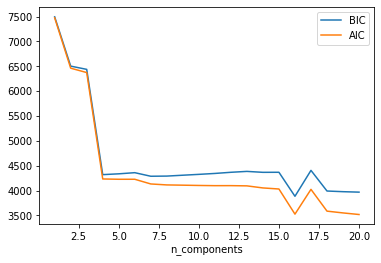

In [141]:
#The optimal number of clusters is the value that minimizes the AIC or BIC
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(result)
          for n in n_components]

plt.plot(n_components, [m.bic(result) for m in models], label='BIC')
plt.plot(n_components, [m.aic(result) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

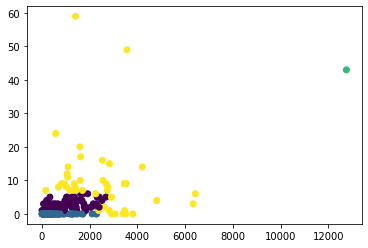

In [145]:
gmm = GaussianMixture(n_components=4).fit(result)
labels = gmm.predict(result)
plt.scatter(result['CUSTOMER_HAL_ID'], result['over_100_bookings'], c=labels, cmap='viridis')

### Hierarchical Clustering

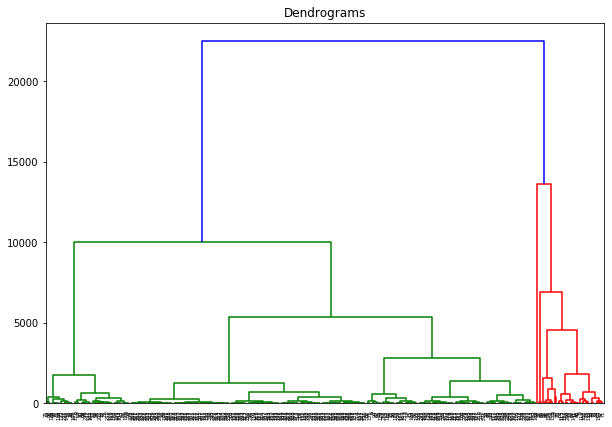

In [146]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(result, method='ward'))

Since there are some outliers, let's not put the line too high. Instead first let us choose roughly 10000 as a line. and then 5000. 

In [147]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(result)

array([1, 1, 3, 1, 0, 0, 1, 1, 3, 3, 3, 0, 3, 1, 1, 0, 0, 3, 1, 3, 3, 0,
       3, 1, 1, 0, 1, 1, 1, 1, 1, 3, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 3, 0,
       0, 0, 0, 3, 3, 3, 1, 3, 0, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 3, 0,
       0, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 1, 0, 1, 1, 0, 1, 1, 3, 1, 1, 1,
       1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 3, 1, 0, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 0, 1, 0, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 3, 1, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,

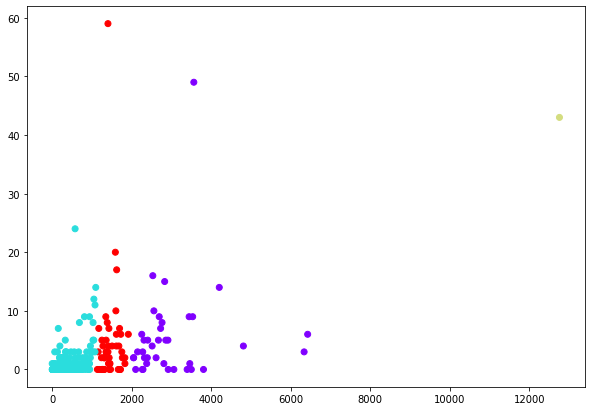

In [148]:
plt.figure(figsize=(10, 7))
plt.scatter(result['CUSTOMER_HAL_ID'], result['over_100_bookings'], c=cluster.labels_, cmap='rainbow')

In [149]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')  
cluster.fit_predict(result)

array([1, 2, 3, 1, 0, 0, 1, 1, 3, 3, 3, 0, 3, 1, 1, 0, 0, 3, 1, 3, 3, 0,
       3, 1, 2, 0, 2, 1, 2, 1, 1, 3, 0, 1, 2, 0, 2, 4, 1, 0, 0, 0, 3, 0,
       0, 4, 0, 3, 3, 3, 1, 3, 0, 0, 1, 1, 0, 1, 5, 1, 2, 1, 1, 0, 3, 0,
       0, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 1, 0, 1, 1, 0, 1, 2, 3, 1, 1, 2,
       1, 3, 3, 1, 2, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 2, 0, 0, 0, 1, 1, 2, 1, 3, 2, 0, 1, 3, 2, 2, 1, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 0, 1, 0, 1, 3, 2, 1, 3, 2, 1, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 2, 3, 1, 1, 0, 3, 2, 3, 2, 2, 1, 1, 2, 3, 3, 1, 1,
       3, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 1, 2, 1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0,
       2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 3, 2,

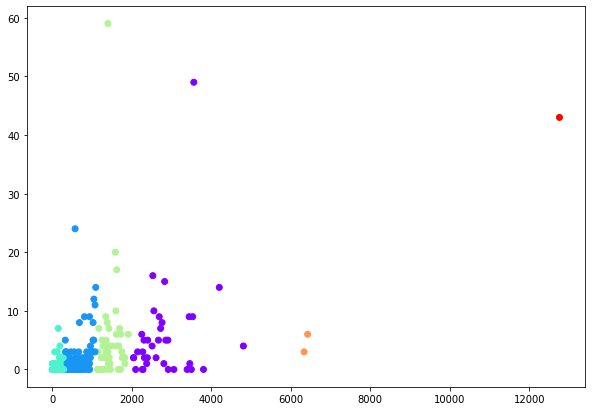

In [150]:
plt.figure(figsize=(10, 7))
plt.scatter(result['CUSTOMER_HAL_ID'], result['over_100_bookings'], c=cluster.labels_, cmap='rainbow')

### Result: 

Again the plot shows some outliers, stations with a lot of customers in both cases. Then there are a few stations that have a lot of occasional customers but few permanent customers. Generelly speaking the amount of occasional customers is always higher than the amount of permanent customers.

### Explanation: 

The stations with little occasional customers and many permanent ones, are probably going to schools or areas with working places where there is no need to go to on occasion since eg. shopping center etc is missing. Whereas the other way around with many occasional customers are places where not many are going often, eg shopping centers or parks etc. The outliers should be looked at separately, but again it is most likely train stations. What would be a senseful cluster number-wise?

## Cluster the stations by amount of bookings, vehicles and hour

Let's think about what actually makes sense to cluster stations for? Would the duration make sense as an attribute for a station? Problably not. Monthly rentals might reduce over time with bad weather but hourly data could still make a difference. How many bookings and vehicles are on the stations over the day? This will most likely produce another linear outcome, but maybe it will point something out.

### Preparation

In [172]:
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'VEHICLE_HAL_ID', 'DATE_BOOKING']]

In [173]:
cluster['hour'] = cluster['DATE_BOOKING'].dt.strftime('%H')

In [174]:
second_cluster

,hour,amount
id,,
252298.0,00,21
250934.0,00,24
254653.0,00,16
258998.0,05,26
240612.0,07,8471
...,...,...
227471.0,21,123
250669.0,22,268
231638.0,22,93


In [175]:
second_cluster = cluster.groupby(['START_RENTAL_ZONE_HAL_ID', 'hour'], as_index = False)['BOOKING_HAL_ID'].count()

In [176]:
second_cluster

,START_RENTAL_ZONE_HAL_ID,hour,BOOKING_HAL_ID
0,3710.0,00,44
1,3710.0,01,27
2,3710.0,02,17
3,3710.0,03,23
4,3710.0,04,23
...,...,...,...
7422,259001.0,19,1
7423,259001.0,20,7
7424,259001.0,21,5
7425,259001.0,22,1


In [100]:
second_cluster = second_cluster.rename(columns={"START_RENTAL_ZONE_HAL_ID": "id"})

In [101]:
second_cluster = second_cluster.rename(columns={"BOOKING_HAL_ID": "amount"})

In [102]:
indices = second_cluster.groupby('id')['amount'].idxmax

In [103]:
second_cluster = second_cluster.loc[indices]

In [104]:
second_cluster = second_cluster.set_index('id')

In [119]:
second_cluster = second_cluster.sort_values(by='hour')

In [120]:
second_cluster

,hour,amount
id,,
252298.0,00,21
250934.0,00,24
254653.0,00,16
258998.0,05,26
240612.0,07,8471
...,...,...
227471.0,21,123
250669.0,22,268
231638.0,22,93


### K-Means

In [121]:
#scale values
scaler = StandardScaler()
scaler.fit(second_cluster)
X_scaled = scaler.transform(second_cluster)
X_scaled_df = pd.DataFrame(X_scaled, columns=second_cluster.columns, index=second_cluster.index)
X_scaled_df.head()

,hour,amount
id,,
252298.0,-2.539653,-0.516222
250934.0,-2.539653,-0.512381
254653.0,-2.539653,-0.522624
258998.0,-1.537403,-0.509820
240612.0,-1.136503,10.302975


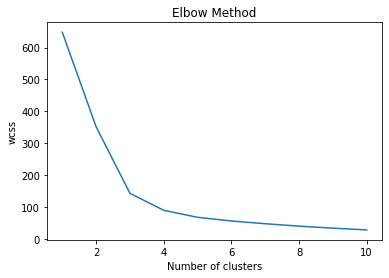

In [122]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

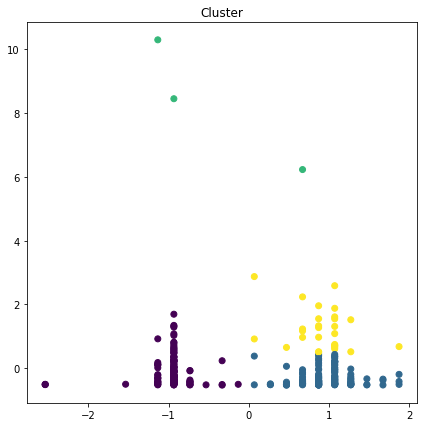

In [123]:
#plot the k-means
means = KMeans(n_clusters=4, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Cluster")

plt.show()

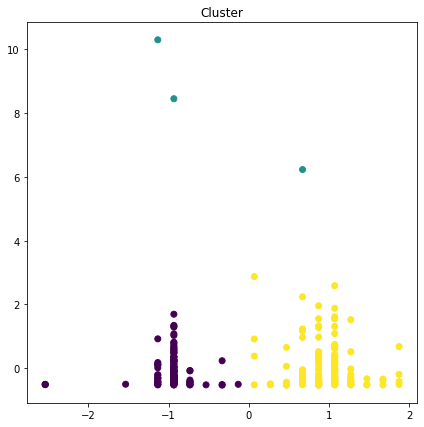

In [124]:
#plot the k-means
means = KMeans(n_clusters=3, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Cluster")

plt.show()

### Gaussian Mixture

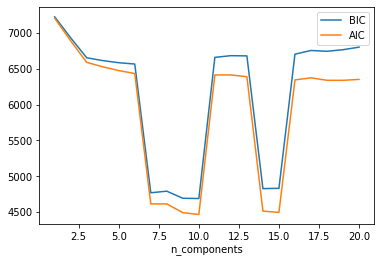

In [125]:
#The optimal number of clusters is the value that minimizes the AIC or BIC
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(second_cluster)
          for n in n_components]

plt.plot(n_components, [m.bic(second_cluster) for m in models], label='BIC')
plt.plot(n_components, [m.aic(second_cluster) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

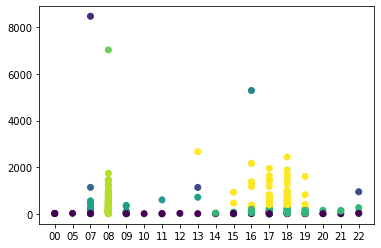

In [126]:
gmm = GaussianMixture(n_components=10).fit(second_cluster)
labels = gmm.predict(second_cluster)
plt.scatter(second_cluster['hour'], second_cluster['amount'], c=labels, cmap='viridis')

You can see that it is starting to devide into the time intervals, eg. hour 8 as very busy is an own cluster here. However, the amount of clusters is still too high and makes little sense by now if you look at the outliers. 

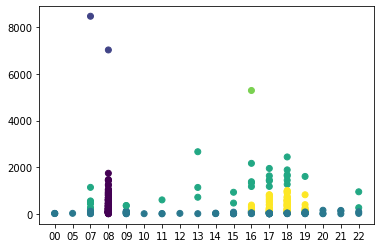

In [127]:
gmm = GaussianMixture(n_components=6).fit(second_cluster)
labels = gmm.predict(second_cluster)
plt.scatter(second_cluster['hour'], second_cluster['amount'], c=labels, cmap='viridis')

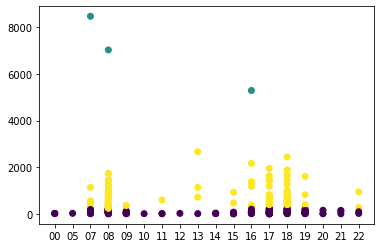

In [144]:
gmm = GaussianMixture(n_components=3).fit(second_cluster)
labels = gmm.predict(second_cluster)
plt.scatter(second_cluster['hour'], second_cluster['amount'], c=labels, cmap='viridis')

The first amount of clusters seems very unlikely, but the second one seems to cluster after the amount of bookings. 

### Hierarchical Clustering

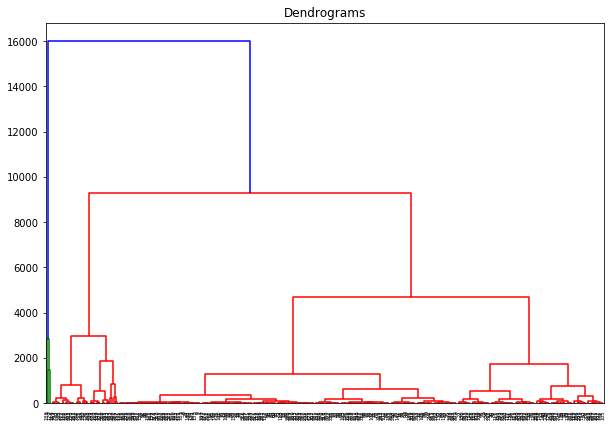

In [128]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(second_cluster, method='ward'))

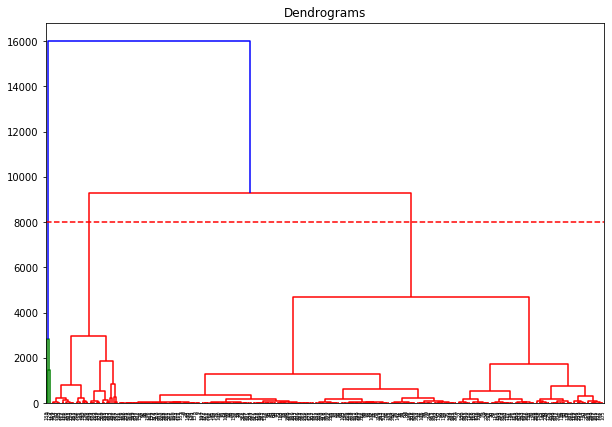

In [129]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(second_cluster, method='ward'))
plt.axhline(y=8000, color='r', linestyle='--')

The longest vertical line withouth horizontal disturbance is the line in the left corner. The middle should lie around 8000, which is crossed by 3 vertical lines.

In [130]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(second_cluster)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 1, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0,

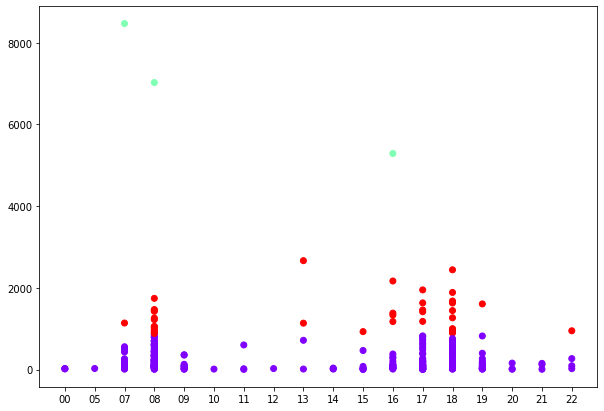

In [131]:
plt.figure(figsize=(10, 7))
plt.scatter(second_cluster['hour'], second_cluster['amount'], c=cluster.labels_, cmap='rainbow')

### Result:

There are a lot of stations that have their highest of bookinf over the day, even though this is still a very low amount of bookings. There are again very few that have an unnaturally high amount. This falls into the time of the working hours, so might be a true result. It might as well be outliers though. Majority of clusters makes a break at around 1000 bookings and starts the second cluster until around 30000. After that just the "outliers" form a cluster. No cluster algorithm showed clusters in the sense of separating into different hour intervals, which might be a result of the distance metrics. However, it seems reasonable that most stations have their high point around the working hours. In between there are relatively few stations that have their highest point. 

### Explanation: 

The busiest hours are the usual working hours, hence it is no surprise that there you find the stations with the max amount of bookings an hour. 

## Cluster the stations by amount of bookings, vehicles and day


### Preparation

In [145]:
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'VEHICLE_HAL_ID', 'DATE_BOOKING']]

In [146]:
cluster['day'] = cluster['DATE_BOOKING'].dt.strftime('%w')

In [147]:
third_cluster = cluster.groupby(['START_RENTAL_ZONE_HAL_ID', 'day'], as_index = False)['BOOKING_HAL_ID'].count()

In [150]:
third_cluster = third_cluster.rename(columns={"START_RENTAL_ZONE_HAL_ID": "id"})
third_cluster = third_cluster.rename(columns={"BOOKING_HAL_ID": "amount"})
third_cluster

,id,day,amount
0,3710.0,0,341
1,3710.0,1,258
2,3710.0,2,242
3,3710.0,3,262
4,3710.0,4,304
...,...,...,...
2258,259001.0,2,9
2259,259001.0,3,2
2260,259001.0,4,4
2261,259001.0,5,3


In [151]:
indices = third_cluster.groupby('id')['amount'].idxmax

In [152]:
third_cluster = third_cluster.loc[indices]

In [153]:
third_cluster = third_cluster.set_index('id')

In [154]:
third_cluster = third_cluster.sort_values(by='day')

In [155]:
third_cluster

,day,amount
id,,
3710.0,0,341
226263.0,0,558
28969.0,0,1232
252298.0,0,50
250337.0,0,415
...,...,...
250548.0,6,568
250540.0,6,15
227447.0,6,776


### K-Means

In [156]:
#scale values
scaler = StandardScaler()
scaler.fit(third_cluster)
X_scaled = scaler.transform(third_cluster)
X_scaled_df = pd.DataFrame(X_scaled, columns=third_cluster.columns, index=third_cluster.index)
X_scaled_df.head()

,day,amount
id,,
3710.0,-1.878553,-0.267437
226263.0,-1.878553,-0.034234
28969.0,-1.878553,0.690095
252298.0,-1.878553,-0.580167
250337.0,-1.878553,-0.187912


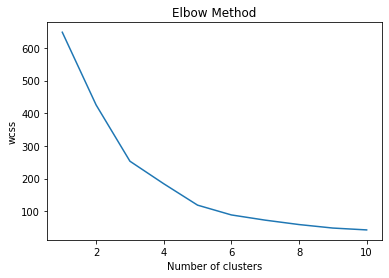

In [157]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

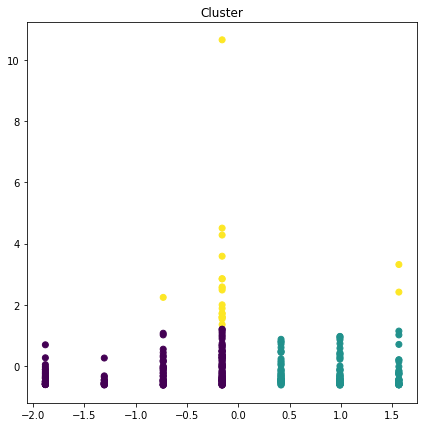

In [158]:
#plot the k-means
means = KMeans(n_clusters=3, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Cluster")

plt.show()

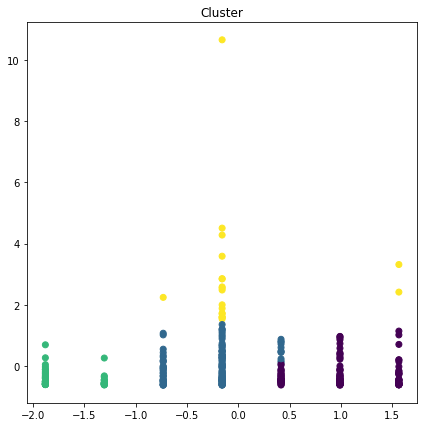

In [159]:
#plot the k-means
means = KMeans(n_clusters=4, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Cluster")

plt.show()

### Gaussian Mixture

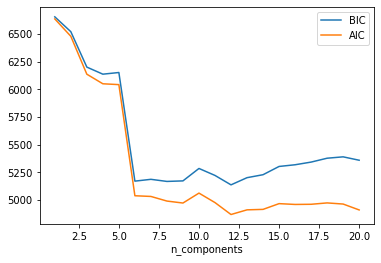

In [160]:
#The optimal number of clusters is the value that minimizes the AIC or BIC
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(third_cluster)
          for n in n_components]

plt.plot(n_components, [m.bic(third_cluster) for m in models], label='BIC')
plt.plot(n_components, [m.aic(third_cluster) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

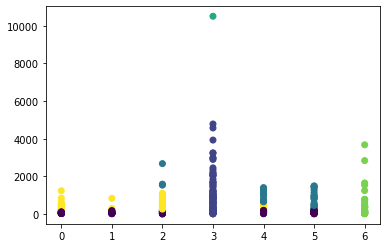

In [163]:
gmm = GaussianMixture(n_components=6).fit(third_cluster)
labels = gmm.predict(third_cluster)
plt.scatter(third_cluster['day'], third_cluster['amount'], c=labels, cmap='viridis')

### Hierarchical Clustering

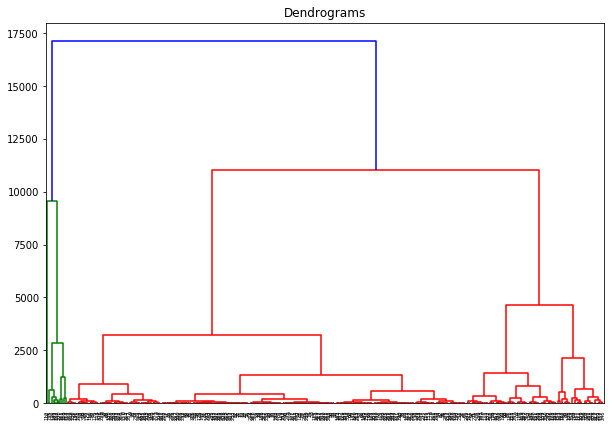

In [167]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(third_cluster, method='ward'))

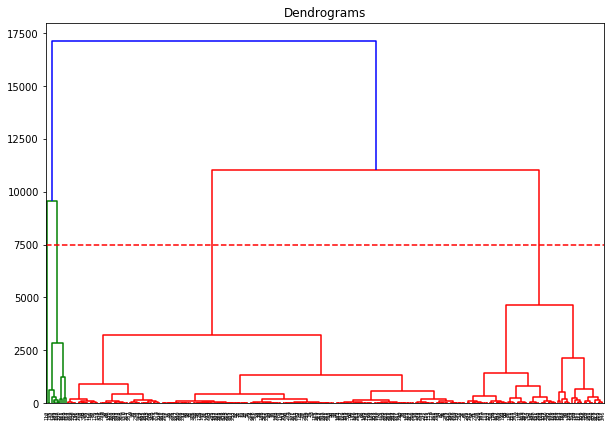

In [168]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(third_cluster, method='ward'))
plt.axhline(y=7500, color='r', linestyle='--')

In [169]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(third_cluster)

array([2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2,
       0, 0, 2, 2, 1, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0,
       2, 2, 3, 2, 2, 2, 0, 0, 1, 2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0,
       2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       0, 1, 0, 0, 1, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2,
       0, 2, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1,

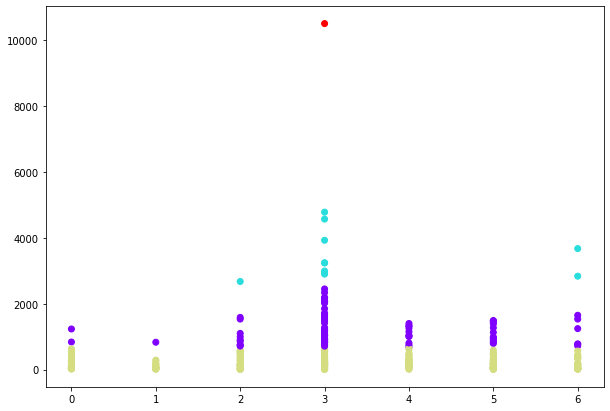

In [170]:
plt.figure(figsize=(10, 7))
plt.scatter(third_cluster['day'], third_cluster['amount'], c=cluster.labels_, cmap='rainbow')

### Result:

The highest variations for the day is Thursday. Again there is one outlier that had a lot bookings on a Thursday. The stations with the lowest amount of bookings as a high are situtated at Monday and Tuesday. Again there are relatively few stations with a high point of bookings. 

# Clustering with Customers

## Stations with the amount of bookings and customers

###  Preparation

In [256]:
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'CUSTOMER_HAL_ID']]

In [257]:
cluster4 = cluster.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False)['BOOKING_HAL_ID'].count()
cluster4 = cluster4.set_index('START_RENTAL_ZONE_HAL_ID')

In [258]:
cluster4

,BOOKING_HAL_ID
START_RENTAL_ZONE_HAL_ID,
3710.0,2017
3717.0,810
3916.0,4051
3954.0,2030
3961.0,9125
...,...
258996.0,344
258998.0,182
258999.0,78


In [259]:
cluster5 = cluster.groupby(by='START_RENTAL_ZONE_HAL_ID', as_index=False).agg({'CUSTOMER_HAL_ID': pd.Series.nunique})
cluster5 = cluster5.set_index('START_RENTAL_ZONE_HAL_ID')

In [260]:
cluster5


,CUSTOMER_HAL_ID
START_RENTAL_ZONE_HAL_ID,
3710.0,468
3717.0,211
3916.0,1443
3954.0,938
3961.0,3807
...,...
258996.0,91
258998.0,81
258999.0,36


In [261]:
cluster4 = cluster4.merge(cluster5, left_index=True, right_index=True)
cluster4

,BOOKING_HAL_ID,CUSTOMER_HAL_ID
START_RENTAL_ZONE_HAL_ID,,
3710.0,2017,468
3717.0,810,211
3916.0,4051,1443
3954.0,2030,938
3961.0,9125,3807
...,...,...
258996.0,344,91
258998.0,182,81
258999.0,78,36


### K-Means

In [204]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster4)
X_scaled = scaler.transform(cluster4)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster4.columns, index=cluster4.index)
X_scaled_df.head()

,BOOKING_HAL_ID,CUSTOMER_HAL_ID
START_RENTAL_ZONE_HAL_ID,,
3710.0,-0.245497,-0.333693
3717.0,-0.478362,-0.549923
3916.0,0.146920,0.486634
3954.0,-0.242989,0.061747
3961.0,1.125840,2.475613


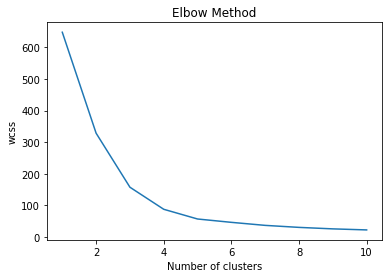

In [205]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

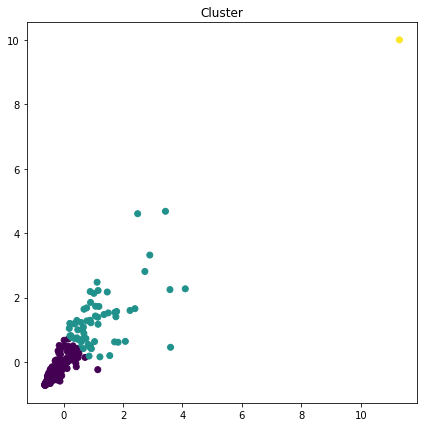

In [206]:
#plot the k-means
means = KMeans(n_clusters=3, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Cluster")

plt.show()

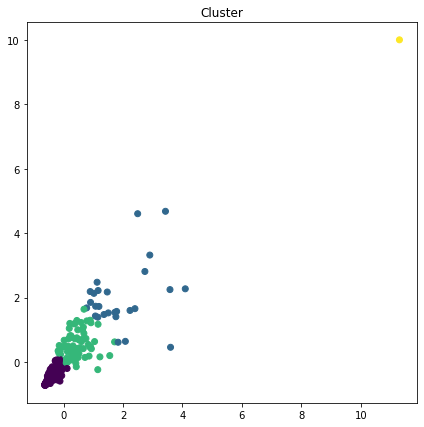

In [207]:
#plot the k-means
means = KMeans(n_clusters=4, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Cluster")

plt.show()

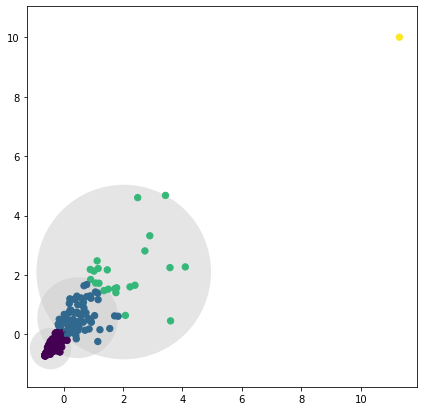

In [208]:
plt.figure(figsize = (7,7))
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
plot_kmeans(means, X_scaled)

### Gaussian Mixture

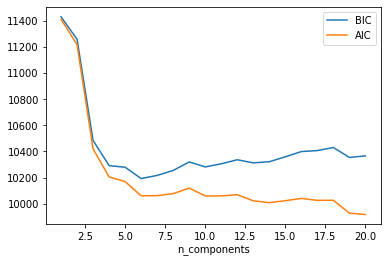

In [210]:
#The optimal number of clusters is the value that minimizes the AIC or BIC
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(cluster4)
          for n in n_components]

plt.plot(n_components, [m.bic(cluster4) for m in models], label='BIC')
plt.plot(n_components, [m.aic(cluster4) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

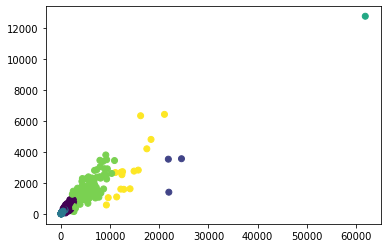

In [211]:
gmm = GaussianMixture(n_components=6).fit(cluster4)
labels = gmm.predict(cluster4)
plt.scatter(cluster4['BOOKING_HAL_ID'], cluster4['CUSTOMER_HAL_ID'], c=labels, cmap='viridis')

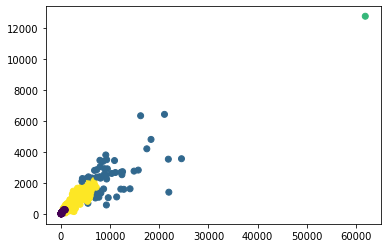

In [212]:
gmm = GaussianMixture(n_components=4).fit(cluster4)
labels = gmm.predict(cluster4)
plt.scatter(cluster4['BOOKING_HAL_ID'], cluster4['CUSTOMER_HAL_ID'], c=labels, cmap='viridis')

###  Hierarchical Clustering

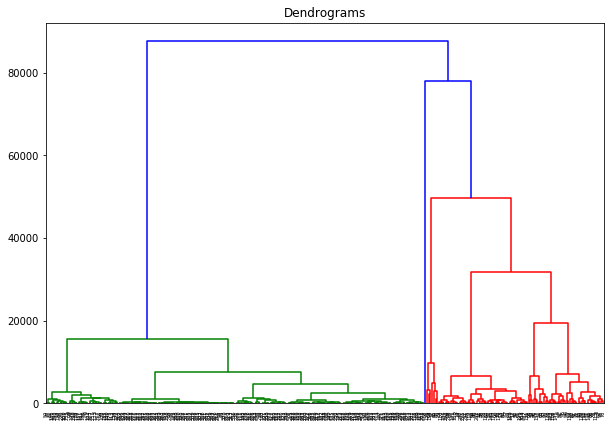

In [21]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(cluster4, method='ward'))

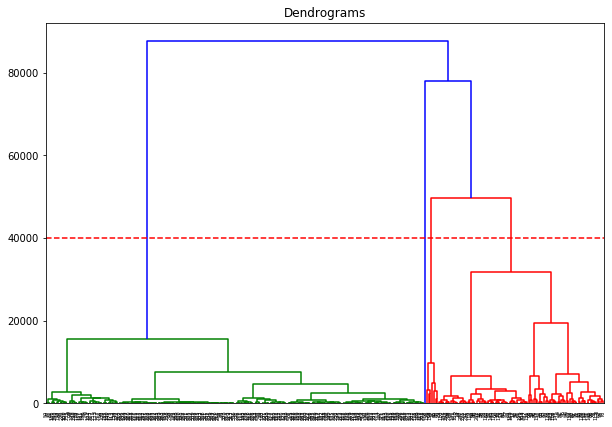

In [22]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(cluster4, method='ward'))
plt.axhline(y=40000, color='r', linestyle='--')
#we could also place this line a bit below if we say we treat the blue lines as outliers. Hence, later we will build two
#clusters, one with 4 one with 5 clusters

In [215]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(cluster4)

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 3, 1, 0, 0, 0, 0, 0,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 3,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 3, 0, 3, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

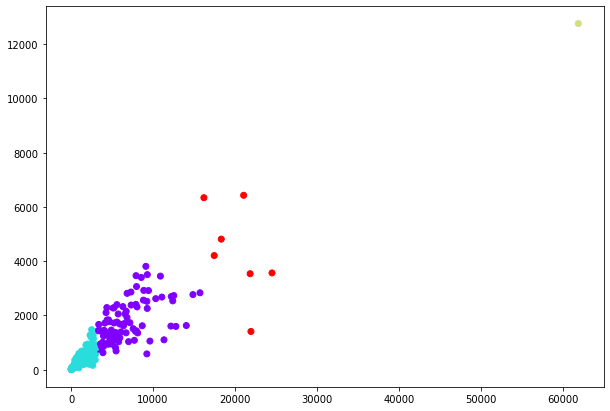

In [216]:
plt.figure(figsize=(10, 7))
plt.scatter(cluster4['BOOKING_HAL_ID'], cluster4['CUSTOMER_HAL_ID'], c=cluster.labels_, cmap='rainbow')

In [41]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')  
cluster.fit_predict(cluster4)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 2,
       0, 0, 1, 4, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

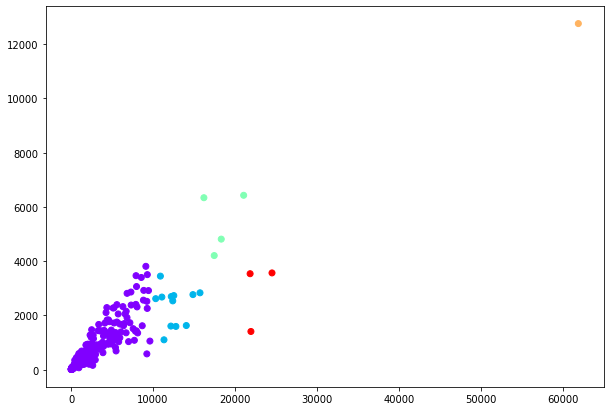

In [42]:
plt.figure(figsize=(10, 7))
plt.scatter(cluster4['BOOKING_HAL_ID'], cluster4['CUSTOMER_HAL_ID'], c=cluster.labels_, cmap='rainbow')

### Result: 

There is one cluster with very little customers and bookings, the lines are roughly 2000 customer and 4000 bookings. Another cluster has a wider area but still more customers, the lines are roughly 17000 bookings and 4000 customers. Then the next cluster has barely any stations but still a few. The lines are wide. There are those that have relatively little bookings but many customers and the other way around, little customers but many bookings. Then again there is one station that is far away from all others and makes it own cluster with many bookings and many customers. 

### Explanation: 

Most likely, the first cluster with very few customers and bookings are stations that aren't used very often. The next cluster with a higher variance, sometimes relatively much bookings with a few customers might be those stations that are used by customers going to work or school, also possible would be shopping centers etc. that are often used. Then next clusters are most probably those that go to very specific places, e.g. a train station. It might be possible to find more information when we see when these stations are accessed. 

## Stations over amount of bookings/customers the hour |||

### Preparation

In [285]:
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'CUSTOMER_HAL_ID', 'DATE_BOOKING']]

In [286]:
cluster['hour'] = cluster['DATE_BOOKING'].dt.strftime('%H')

In [287]:
cluster6 = cluster.groupby(['START_RENTAL_ZONE_HAL_ID', 'hour'], as_index = False)['BOOKING_HAL_ID'].count()
cluster6 = cluster6.set_index('START_RENTAL_ZONE_HAL_ID')
cluster6

,hour,BOOKING_HAL_ID
START_RENTAL_ZONE_HAL_ID,,
3710.0,00,44
3710.0,01,27
3710.0,02,17
3710.0,03,23
3710.0,04,23
...,...,...
259001.0,19,1
259001.0,20,7
259001.0,21,5


In [288]:
cluster5 = cluster.groupby(['START_RENTAL_ZONE_HAL_ID', 'hour'], as_index = False)['CUSTOMER_HAL_ID'].agg({'CUSTOMER_HAL_ID': pd.Series.nunique})
cluster5 = cluster5.set_index('START_RENTAL_ZONE_HAL_ID')
cluster5

,hour,CUSTOMER_HAL_ID
START_RENTAL_ZONE_HAL_ID,,
3710.0,00,35
3710.0,01,24
3710.0,02,16
3710.0,03,19
3710.0,04,13
...,...,...
259001.0,19,1
259001.0,20,5
259001.0,21,3


In [289]:
cluster5 = cluster5.merge(cluster6, how='left', left_on=['START_RENTAL_ZONE_HAL_ID', 'hour'], right_on=['START_RENTAL_ZONE_HAL_ID', 'hour'])
cluster5

,hour,CUSTOMER_HAL_ID,BOOKING_HAL_ID
START_RENTAL_ZONE_HAL_ID,,,
3710.0,00,35,44
3710.0,01,24,27
3710.0,02,16,17
3710.0,03,19,23
3710.0,04,13,23
...,...,...,...
259001.0,19,1,1
259001.0,20,5,7
259001.0,21,3,5


### Preparation for Step 2.3

This is for the clustering in the step 2.3. that we will need later!

In [292]:
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'CUSTOMER_HAL_ID', 'DATE_BOOKING']]

In [293]:
cluster['day'] = cluster['DATE_BOOKING'].dt.strftime('%w')

In [294]:
cluster10 = cluster.groupby(['START_RENTAL_ZONE_HAL_ID', 'day'], as_index = False)['BOOKING_HAL_ID'].count()
cluster10 = cluster10.set_index('START_RENTAL_ZONE_HAL_ID')
cluster10

,day,BOOKING_HAL_ID
START_RENTAL_ZONE_HAL_ID,,
3710.0,0,341
3710.0,1,258
3710.0,2,242
3710.0,3,262
3710.0,4,304
...,...,...
259001.0,2,9
259001.0,3,2
259001.0,4,4


In [295]:
cluster11 = cluster.groupby(['START_RENTAL_ZONE_HAL_ID', 'day'], as_index = False)['CUSTOMER_HAL_ID'].agg({'CUSTOMER_HAL_ID': pd.Series.nunique})
cluster11 = cluster11.set_index('START_RENTAL_ZONE_HAL_ID')
cluster11

,day,CUSTOMER_HAL_ID
START_RENTAL_ZONE_HAL_ID,,
3710.0,0,178
3710.0,1,119
3710.0,2,104
3710.0,3,120
3710.0,4,134
...,...,...
259001.0,2,4
259001.0,3,2
259001.0,4,4


In [296]:
cluster11 = cluster11.merge(cluster10, how='left', left_on=['START_RENTAL_ZONE_HAL_ID', 'day'], right_on=['START_RENTAL_ZONE_HAL_ID', 'day'])
cluster11 = cluster11.rename(columns={"CUSTOMER_HAL_ID": "mean_customer_day", "BOOKING_HAL_ID": "mean_booking_day"})


In [297]:
cluster11

,day,mean_customer_day,mean_booking_day
START_RENTAL_ZONE_HAL_ID,,,
3710.0,0,178,341
3710.0,1,119,258
3710.0,2,104,242
3710.0,3,120,262
3710.0,4,134,304
...,...,...,...
259001.0,2,4,9
259001.0,3,2,2
259001.0,4,4,4


### K-Means

In [246]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster5)
X_scaled = scaler.transform(cluster5)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster5.columns, index=cluster5.index)
X_scaled_df.head()

,hour,CUSTOMER_HAL_ID,BOOKING_HAL_ID
START_RENTAL_ZONE_HAL_ID,,,
3710.0,-1.714921,-0.303404,-0.315595
3710.0,-1.569195,-0.382969,-0.369515
3710.0,-1.423469,-0.440835,-0.401233
3710.0,-1.277744,-0.419135,-0.382202
3710.0,-1.132018,-0.462534,-0.382202


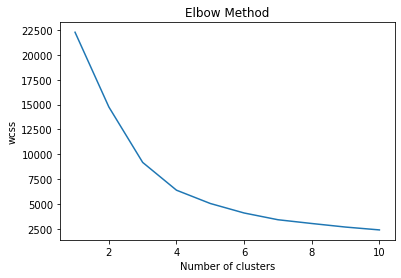

In [247]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [248]:
means = KMeans(n_clusters=4)
means.fit(X_scaled)
x_pred = means.predict(X_scaled)

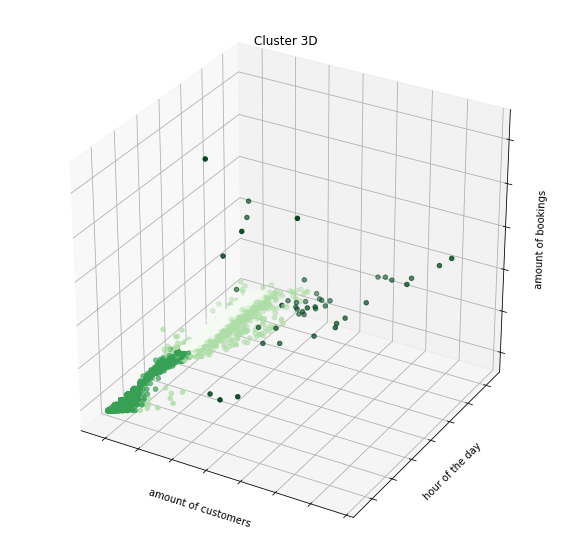

In [256]:
# 3D Plot
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')
fignum = 1
fig = plt.figure(fignum, figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(X_scaled[:, 1], X_scaled[:, 0], X_scaled[:, 2], c=x_pred, cmap='Greens')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('amount of customers')
ax.set_ylabel('hour of the day')
ax.set_zlabel('amount of bookings')
ax.set_title('Cluster 3D')
ax.dist = 10

fig.show()

### Gaussian Mixture

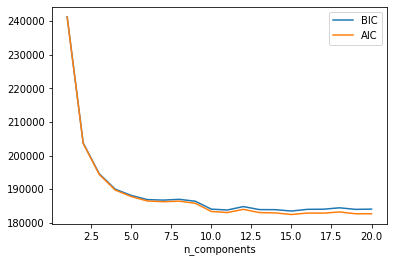

In [257]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(cluster5)
          for n in n_components]

plt.plot(n_components, [m.bic(cluster5) for m in models], label='BIC')
plt.plot(n_components, [m.aic(cluster5) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

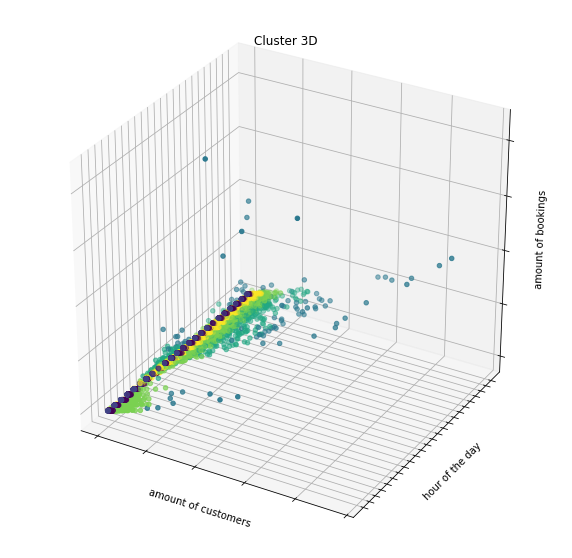

In [260]:
gmm = GaussianMixture(n_components=6).fit(cluster5)
labels = gmm.predict(cluster5)

zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

fig = plt.figure(fignum, figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(cluster5['CUSTOMER_HAL_ID'], cluster5['hour'], cluster5['BOOKING_HAL_ID'], c=labels, cmap='viridis')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('amount of customers')
ax.set_ylabel('hour of the day')
ax.set_zlabel('amount of bookings')
ax.set_title('Cluster 3D')
ax.dist = 10

fig.show()

### Hierarchical Clustering

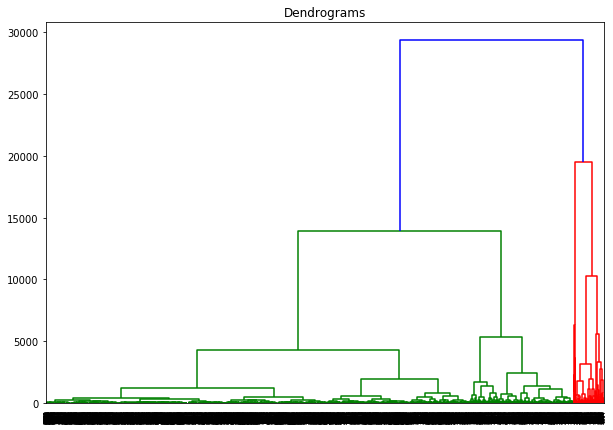

In [261]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(cluster5, method='ward'))

In [262]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(cluster5)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

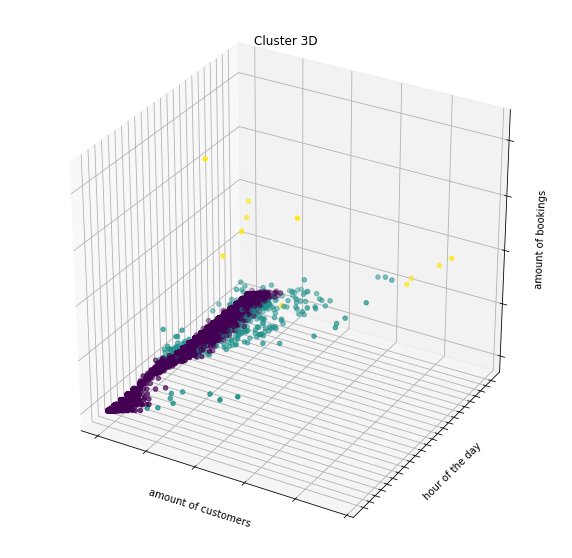

In [263]:
# 3D Plot
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')
fignum = 1
fig = plt.figure(fignum, figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(cluster5['CUSTOMER_HAL_ID'], cluster5['hour'], cluster5['BOOKING_HAL_ID'], c=cluster.labels_, cmap='viridis')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('amount of customers')
ax.set_ylabel('hour of the day')
ax.set_zlabel('amount of bookings')
ax.set_title('Cluster 3D')
ax.dist = 10

fig.show()

### Explanation: 

We do not think this showed us anything new except for the things that we already have partly seen in the other clusters. Also each station is represented 7 times here. Is this actually a valid representation? It gave me the idea to check instead with the mean amounts over days and weekdays (if these actually show different results). 

## Stations with amount of bookings, customers and mean over hour/day |||

### Preparation

In [330]:
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'START_RENTAL_ZONE_HAL_ID', 'CUSTOMER_HAL_ID']]

In [331]:
cluster3 = cluster.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False)['BOOKING_HAL_ID'].count()
cluster3 = cluster3.rename(columns={"BOOKING_HAL_ID": "total_bookings"})

In [332]:
cluster4 = cluster.groupby(by='START_RENTAL_ZONE_HAL_ID', as_index=False).agg({'CUSTOMER_HAL_ID': pd.Series.nunique})
cluster4 = cluster4.rename(columns={"CUSTOMER_HAL_ID": "total_customers"})

In [333]:
cluster4 = cluster4.merge(cluster3, left_index=True, right_index=True)

In [336]:
cluster4 = cluster4.drop('START_RENTAL_ZONE_HAL_ID_x', axis=1)
cluster4 = cluster4.drop('START_RENTAL_ZONE_HAL_ID_y', axis=1)
cluster4

,total_customers,total_bookings
0,468,2017
1,211,810
2,1443,4051
3,938,2030
4,3807,9125
...,...,...
319,91,344
320,81,182
321,36,78
322,23,80


In [337]:
a = cluster5.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False)['CUSTOMER_HAL_ID'].mean()
a = a.rename(columns={"CUSTOMER_HAL_ID": "mean_customers_hour"})

In [338]:
b = cluster5.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False)['BOOKING_HAL_ID'].mean()
b = b.rename(columns={"BOOKING_HAL_ID": "mean_booking_hour"})

In [339]:
c = cluster11.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False)['mean_customer_day'].mean()
c

,mean_customer_day
0,133.142857
1,59.428571
2,339.000000
3,175.428571
4,874.428571
...,...
319,29.428571
320,17.000000
321,7.571429
322,6.285714


In [299]:
d = cluster11.groupby(['START_RENTAL_ZONE_HAL_ID'], as_index = False)['mean_booking_day'].mean()
d

,mean_booking_day
0,288.142857
1,115.714286
2,578.714286
3,290.000000
4,1303.571429
...,...
319,49.142857
320,26.000000
321,11.142857
322,11.428571


In [340]:
cluster6 = pd.concat([cluster4, a, b, c, d], axis=1)
cluster6

,total_customers,total_bookings,mean_customers_hour,mean_booking_hour,mean_customer_day,mean_booking_day
0,468,2017,46.833333,84.041667,133.142857,288.142857
1,211,810,19.458333,33.750000,59.428571,115.714286
2,1443,4051,106.000000,168.791667,339.000000,578.714286
3,938,2030,54.791667,84.583333,175.428571,290.000000
4,3807,9125,272.625000,380.208333,874.428571,1303.571429
...,...,...,...,...,...,...
319,91,344,9.727273,15.636364,29.428571,49.142857
320,81,182,5.478261,7.913043,17.000000,26.000000
321,36,78,3.625000,4.875000,7.571429,11.142857
322,23,80,2.882353,4.705882,6.285714,11.428571


### sns-plot

In [341]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster6)
X_scaled = scaler.transform(cluster6)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster6.columns, index=cluster6.index)
X_scaled_df.head()

,total_customers,total_bookings,mean_customers_hour,mean_booking_hour,mean_customer_day,mean_booking_day
0,-0.333693,-0.245497,-0.245194,-0.248702,-0.277393,-0.245502
1,-0.549923,-0.478362,-0.494095,-0.481815,-0.497307,-0.478368
2,0.486634,0.146920,0.292765,0.144134,0.336745,0.146916
3,0.061747,-0.242989,-0.172835,-0.246191,-0.151241,-0.242994
4,2.475613,1.125840,1.807764,1.124100,1.934102,1.125838


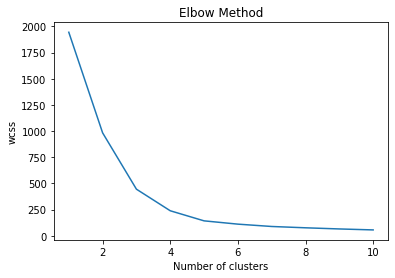

In [342]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [346]:
means = KMeans(n_clusters=4)
means.fit(X_scaled)
means.predict(X_scaled)

array([1, 1, 3, 1, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3,
       3, 1, 1, 0, 1, 3, 1, 1, 3, 3, 0, 1, 1, 3, 1, 0, 1, 0, 0, 0, 3, 3,
       0, 0, 3, 3, 3, 3, 3, 3, 0, 3, 1, 1, 3, 3, 2, 1, 1, 3, 3, 0, 3, 0,
       3, 3, 0, 0, 0, 0, 3, 3, 0, 3, 3, 1, 0, 1, 3, 0, 1, 1, 3, 3, 3, 1,
       1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 1, 3, 1, 0, 1, 1, 3, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1,
       1, 1, 0, 0, 0, 1, 3, 1, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

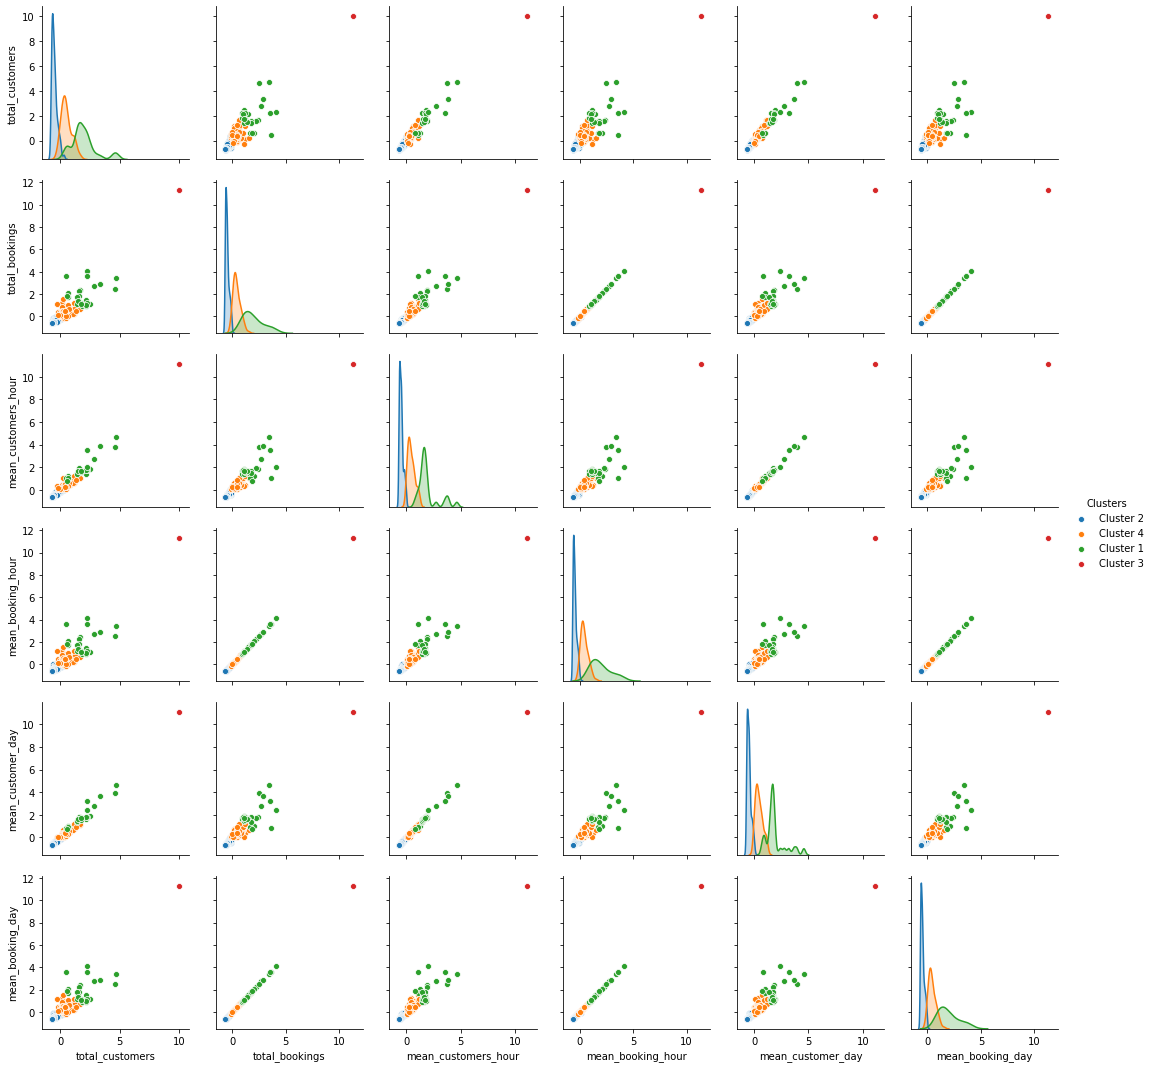

In [382]:
numbers = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Clusters"]
X_scaled_df["Clusters"] = means.predict(X_scaled)
X_scaled_df["Clusters"] = X_scaled_df["Clusters"].apply(lambda x: numbers[x])
sns.pairplot(data=X_scaled_df, hue="Clusters")

### Result:

No real info in comparison to before. Basically just more linear lines than (sometimes with outliers) just like the clustering from total customers vs total bookings. 

## Customer to their amount of bookings and the mean duration

### Preparation

#### Seasonal Splitting

##### Winter

In [7]:
winter = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'duration', 'CUSTOMER_HAL_ID', 'DATE_BOOKING']]

In [8]:
start_date1 = '2015-01-01 00:00:00'
end_date1 = '2015-02-28 23:59:59'
filtered_dates_winter_one = (winter['DATE_BOOKING'] >= start_date1) & (winter['DATE_BOOKING'] <= end_date1) 
booking_set_frankfurt_winter_one = winter.loc[filtered_dates_winter_one]

In [9]:
start_date2 = '2015-12-01 00:00:00'
end_date2 = '2016-02-29 23:59:59'
filtered_dates_winter_two = (winter['DATE_BOOKING'] >= start_date2) & (winter['DATE_BOOKING'] <= end_date2) 
booking_set_frankfurt_winter_two = winter.loc[filtered_dates_winter_two]

In [10]:
#winter
start_date3 = '2016-12-01 00:00:00'
end_date3 = '2016-12-31 23:59:59'
filtered_dates_winter_three = (winter['DATE_BOOKING'] >= start_date3) & (winter['DATE_BOOKING'] <= end_date3) 
booking_set_frankfurt_winter_three = winter.loc[filtered_dates_winter_three]

In [11]:
frames = [booking_set_frankfurt_winter_one, booking_set_frankfurt_winter_two, booking_set_frankfurt_winter_three]
winters = pd.concat(frames)

##### Spring

In [12]:
start_date1 = '2015-03-01 00:00:00'
end_date1 = '2015-05-31 23:59:59'
filtered_dates_spring_one = (winter['DATE_BOOKING'] >= start_date1) & (winter['DATE_BOOKING'] <= end_date1) 
booking_set_frankfurt_spring_one = winter.loc[filtered_dates_spring_one]

,BOOKING_HAL_ID,duration,CUSTOMER_HAL_ID,DATE_BOOKING
4613273,28356212,00:19:50,41BF9F438F9C2FD2DA32580A765DCD21915228B5,2015-03-01 00:00:11
4613211,28356262,00:12:17,6E1CC3BCC2753E711020B2211A0BBB084FF8C74D,2015-03-01 00:11:22
4614362,28356284,00:05:12,7BC01CCB59BCCC126E51533AD71A51AA803C4F48,2015-03-01 00:16:58
4612668,28356309,00:11:31,97D8ED66B7919DF5730FBA97D5053EE2E4D9E599,2015-03-01 00:21:41
4614461,28356391,00:19:20,87B64AB003D251921FD76B7630A8B9A81C6FE778,2015-03-01 00:38:17
...,...,...,...,...
5735664,30141540,00:19:02,027A30F60C6C073273705FE1A4D350651F42B06C,2015-05-31 23:46:10
5740159,30141566,00:14:36,DFE5F40D08A4C9827E569F4D35207FB1E1EBB975,2015-05-31 23:51:55
5732560,30141571,00:19:20,7BDEE207C0143D87699112A2B128EEFFF6009F88,2015-05-31 23:53:12
5735701,30141576,00:08:40,464E639B75E0BD718B21043DA7595ED0C82259C2,2015-05-31 23:54:01


In [13]:
start_date2 = '2016-03-01 00:00:00'
end_date2 = '2016-05-31 23:59:59'
filtered_dates_spring_two = (winter['DATE_BOOKING'] >= start_date1) & (winter['DATE_BOOKING'] <= end_date1) 
booking_set_frankfurt_spring_two = winter.loc[filtered_dates_spring_two]

,BOOKING_HAL_ID,duration,CUSTOMER_HAL_ID,DATE_BOOKING
4613273,28356212,00:19:50,41BF9F438F9C2FD2DA32580A765DCD21915228B5,2015-03-01 00:00:11
4613211,28356262,00:12:17,6E1CC3BCC2753E711020B2211A0BBB084FF8C74D,2015-03-01 00:11:22
4614362,28356284,00:05:12,7BC01CCB59BCCC126E51533AD71A51AA803C4F48,2015-03-01 00:16:58
4612668,28356309,00:11:31,97D8ED66B7919DF5730FBA97D5053EE2E4D9E599,2015-03-01 00:21:41
4614461,28356391,00:19:20,87B64AB003D251921FD76B7630A8B9A81C6FE778,2015-03-01 00:38:17
...,...,...,...,...
5735664,30141540,00:19:02,027A30F60C6C073273705FE1A4D350651F42B06C,2015-05-31 23:46:10
5740159,30141566,00:14:36,DFE5F40D08A4C9827E569F4D35207FB1E1EBB975,2015-05-31 23:51:55
5732560,30141571,00:19:20,7BDEE207C0143D87699112A2B128EEFFF6009F88,2015-05-31 23:53:12
5735701,30141576,00:08:40,464E639B75E0BD718B21043DA7595ED0C82259C2,2015-05-31 23:54:01


In [14]:
frames = [booking_set_frankfurt_spring_one, booking_set_frankfurt_spring_two]
spring = pd.concat(frames)

##### Summer

In [15]:
start_date1 = '2015-06-01 00:00:00'
end_date1 = '2015-08-31 23:59:59'
filtered_dates_summer_one = (winter['DATE_BOOKING'] >= start_date1) & (winter['DATE_BOOKING'] <= end_date1) 
booking_set_frankfurt_summer_one = winter.loc[filtered_dates_summer_one]

In [16]:
start_date2 = '2016-06-01 00:00:00'
end_date2 = '2016-08-31 23:59:59'
filtered_dates_summer_two = (winter['DATE_BOOKING'] >= start_date2) & (winter['DATE_BOOKING'] <= end_date2) 
booking_set_frankfurt_summer_two = winter.loc[filtered_dates_summer_two]

In [17]:
frames = [booking_set_frankfurt_summer_one, booking_set_frankfurt_summer_two]
summer = pd.concat(frames)

##### Fall

In [19]:
start_date1 = '2015-09-01 00:00:00'
end_date1 = '2015-11-30 23:59:59'
filtered_dates_fall_one = (winter['DATE_BOOKING'] >= start_date1) & (winter['DATE_BOOKING'] <= end_date1) 
booking_set_frankfurt_fall_one = winter.loc[filtered_dates_fall_one]

In [20]:
start_date2 = '2016-09-01 00:00:00'
end_date2 = '2016-11-30 23:59:59'
filtered_dates_fall_two = (winter['DATE_BOOKING'] >= start_date2) & (winter['DATE_BOOKING'] <= end_date2) 
booking_set_frankfurt_fall_two = winter.loc[filtered_dates_fall_two]

In [21]:
frames = [booking_set_frankfurt_fall_one, booking_set_frankfurt_fall_two]
fall = pd.concat(frames)

#### Preparation of the cluster tables

In [29]:
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'duration', 'CUSTOMER_HAL_ID']]

In [30]:
cluster

,BOOKING_HAL_ID,duration,CUSTOMER_HAL_ID
4285336,27689041,0 days 00:11:32,0284A643498771058AA8BB3555DF8828D6D08635
4285873,27689080,0 days 00:25:58,E2F878900ACA546F5D3DD11D7DCFF761D205B7BE
4286542,27689151,0 days 00:11:00,4BFADBFCF0460E0B9517D8769FE3610099585392
4286567,27689154,0 days 00:10:33,0DA7FC2ECDEE84F51E8D498A8126BE2DE209993E
4286706,27689156,0 days 00:10:34,C93CE56161BE788668809D903A2CA184B4E93C61
...,...,...,...
14613160,43561784,1 days 09:08:32,9F30DD1C0D061AB3577ADD1BC0C1360CAC3702D1
14613511,43561828,0 days 00:22:31,CDA293642336D184957723DFFD87734B5E6F2CDB
14612056,43561832,0 days 00:08:47,F440BA12F43719BB5E61ED1E59465716A0D5C6C0
14615815,43561863,0 days 00:05:21,EEC46612DCC24C28400BF399C4D9C7BB1D1C69C8


In [32]:
cluster7 = cluster.groupby(by='CUSTOMER_HAL_ID', as_index=False)['BOOKING_HAL_ID'].count()
cluster7 = cluster7.drop('CUSTOMER_HAL_ID', axis=1)

In [33]:
cluster7

,BOOKING_HAL_ID
0,7
1,129
2,6
3,5
4,15
...,...
39847,2
39848,75
39849,1
39850,61


In [34]:
cluster['duration'] = pd.to_numeric(cluster['duration'])
cluster8 = cluster.groupby(["CUSTOMER_HAL_ID"], as_index = False)['duration'].mean()
cluster8['duration'] = pd.to_timedelta(cluster8['duration'])
cluster8 = cluster8.drop('CUSTOMER_HAL_ID', axis=1)
cluster8

,duration
0,00:52:39.142857
1,00:14:43.449612
2,00:08:30.166666
3,00:16:56.200000
4,00:18:04.466666
...,...
39847,23:40:34.500000
39848,00:17:44.920000
39849,00:22:35
39850,00:32:22.393442


In [35]:
cluster7 = pd.concat([cluster7, cluster8], axis=1)


In [36]:
cluster7

,BOOKING_HAL_ID,duration
0,7,00:52:39.142857
1,129,00:14:43.449612
2,6,00:08:30.166666
3,5,00:16:56.200000
4,15,00:18:04.466666
...,...,...
39847,2,23:40:34.500000
39848,75,00:17:44.920000
39849,1,00:22:35
39850,61,00:32:22.393442


### K-Means

In [37]:
cluster7['duration'] = pd.to_numeric(cluster7['duration'])

In [38]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster7)
X_scaled = scaler.transform(cluster7)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster7.columns, index=cluster7.index)
X_scaled_df.head()

,BOOKING_HAL_ID,duration
0,-0.315598,-0.024033
1,1.634543,-0.128908
2,-0.331583,-0.146111
3,-0.347568,-0.122790
4,-0.187720,-0.119644


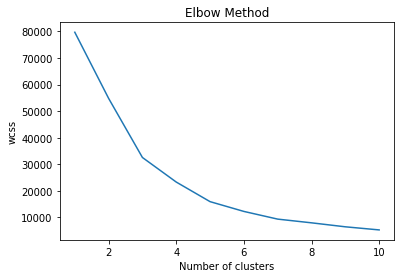

In [39]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

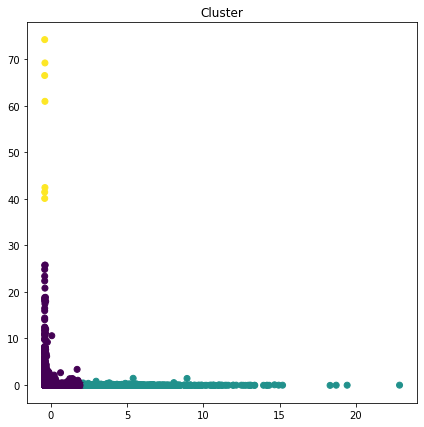

In [40]:
#plot the k-means
means = KMeans(n_clusters=3, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Cluster")

plt.show()

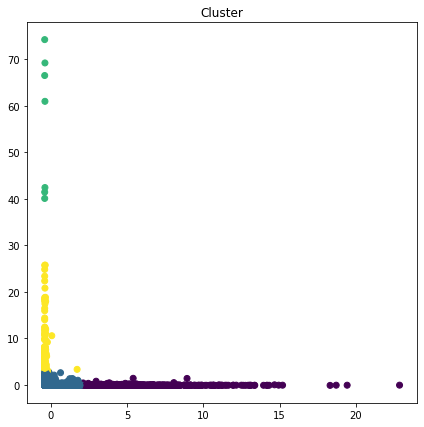

In [41]:
#plot the k-means
means = KMeans(n_clusters=4, init='k-means++', max_iter=300, algorithm='auto')
means.fit(X_scaled_df)
means.predict(X_scaled_df)
x_pred = means.predict(X_scaled_df)
plt.subplots(1, 1, figsize=(7,7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=x_pred)
plt.title("Cluster")

plt.show()

### Gaussian Mixture

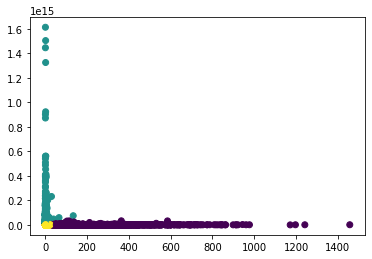

In [428]:
gmm = GaussianMixture(n_components=3).fit(cluster7)
labels = gmm.predict(cluster7)
plt.scatter(cluster7['BOOKING_HAL_ID'], cluster7['duration'], c=labels, cmap='viridis')

### Result:

Since this data set was way bigger than the other one before, it took a lot longer for the HC than the other ones before. So we decided to leave this out for now. K-Means and Gaussian Mixture have shwon the overall distribution by now. There are customers that have a very low amount of bookings with very low duration. Then there are those that have a low amount of bookings with a high duration. And then there are those that have a high amount of amount of bookings with very low duration. 

# Routes

## Routes to Amount of bookings and customers and duration

### Preparation

In [63]:
cluster = booking_set_frankfurt_20152016.loc[:,['BOOKING_HAL_ID', 'END_RENTAL_ZONE', 'START_RENTAL_ZONE', 'CUSTOMER_HAL_ID', 'duration']]

In [64]:
a = cluster.groupby(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], as_index=False)['BOOKING_HAL_ID'].count()

In [65]:
b = cluster.groupby(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], as_index=False).agg({'CUSTOMER_HAL_ID': pd.Series.nunique})

In [66]:
cluster['duration'] = pd.to_numeric(cluster['duration'])
c = cluster.groupby(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], as_index=False)['duration'].mean()

In [67]:
a = a.drop(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], axis=1)
b = b.drop(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], axis=1)
c = c.drop(['END_RENTAL_ZONE', 'START_RENTAL_ZONE'], axis=1)

In [68]:
cluster8 = pd.concat([a, b, c], axis=1)
cluster8

,BOOKING_HAL_ID,CUSTOMER_HAL_ID,duration
0,99,26,3.443465e+12
1,1,1,7.950000e+11
2,4,3,1.021500e+12
3,2,2,8.090000e+11
4,4,3,5.215000e+11
...,...,...,...
47099,3,3,9.250000e+11
47100,1,1,1.083000e+12
47101,5,2,1.079400e+12
47102,7,3,6.027143e+11


### sns-plot

If you rerun the code, remember to cluster the first kmeans and then run the first 3D model. Then go to second with more clsuters and run the next 3D model and so on. In total there are 3. Do that since the variable names haven't been changed yet.

In [69]:
#scale values
scaler = StandardScaler()
scaler.fit(cluster8)
X_scaled = scaler.transform(cluster8)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster8.columns, index=cluster8.index)
X_scaled_df.head()

,BOOKING_HAL_ID,CUSTOMER_HAL_ID,duration
0,0.827717,0.530720,0.110438
1,-0.234380,-0.333465,-0.092323
2,-0.201867,-0.264330,-0.074982
3,-0.223542,-0.298897,-0.091251
4,-0.201867,-0.264330,-0.113262


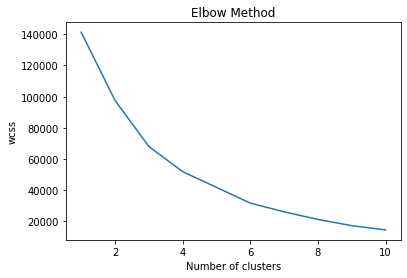

In [70]:
#check for optimal amount of clusters
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_scaled_df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [80]:
means = KMeans(n_clusters=4)
means.fit(X_scaled)
means.predict(X_scaled)
x_pred = means.predict(X_scaled)

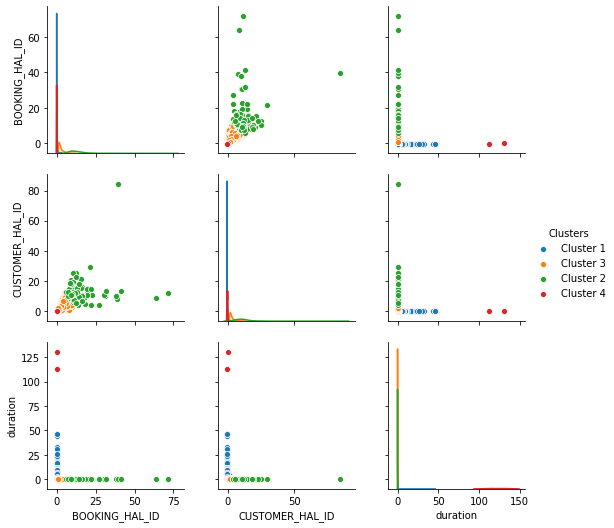

In [81]:
numbers = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Clusters"]
X_scaled_df["Clusters"] = means.predict(X_scaled)
X_scaled_df["Clusters"] = X_scaled_df["Clusters"].apply(lambda x: numbers[x])
sns.pairplot(data=X_scaled_df, hue="Clusters")

In [89]:
means = KMeans(n_clusters=5)
means.fit(X_scaled)
means.predict(X_scaled)
x_pred = means.predict(X_scaled)

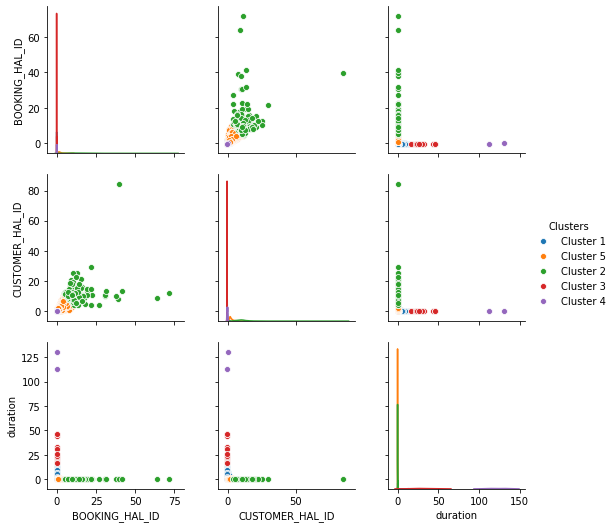

In [90]:
numbers = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Clusters"]
X_scaled_df["Clusters"] = means.predict(X_scaled)
X_scaled_df["Clusters"] = X_scaled_df["Clusters"].apply(lambda x: numbers[x])
sns.pairplot(data=X_scaled_df, hue="Clusters")

In [92]:
means = KMeans(n_clusters=6)
means.fit(X_scaled)
means.predict(X_scaled)
x_pred = means.predict(X_scaled)

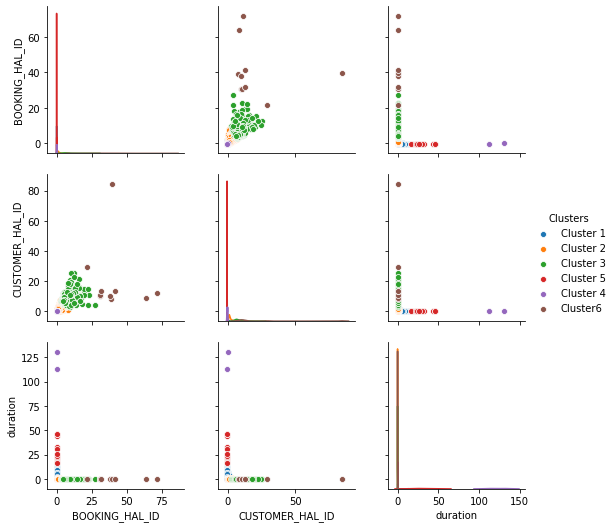

In [93]:
numbers = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster6", "Clusters"]
X_scaled_df["Clusters"] = means.predict(X_scaled)
X_scaled_df["Clusters"] = X_scaled_df["Clusters"].apply(lambda x: numbers[x])
sns.pairplot(data=X_scaled_df, hue="Clusters")

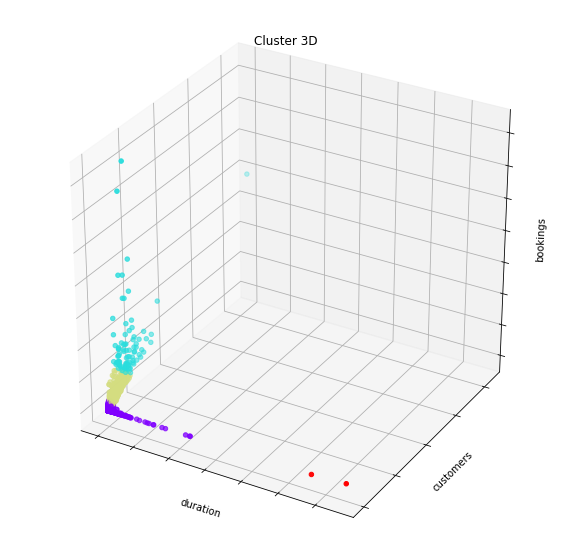

In [86]:
#ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
#plot with 4 clusters
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)

ax.plot3D(xline, yline, zline, 'gray')
fignum = 1
fig = plt.figure(fignum, figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.scatter3D(X_scaled[:, 2], X_scaled[:, 1], X_scaled[:, 0], c=x_pred, cmap='rainbow')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('duration')
ax.set_ylabel('customers')
ax.set_zlabel('bookings')
ax.set_title('Cluster 3D')
ax.dist = 10

fig.show()

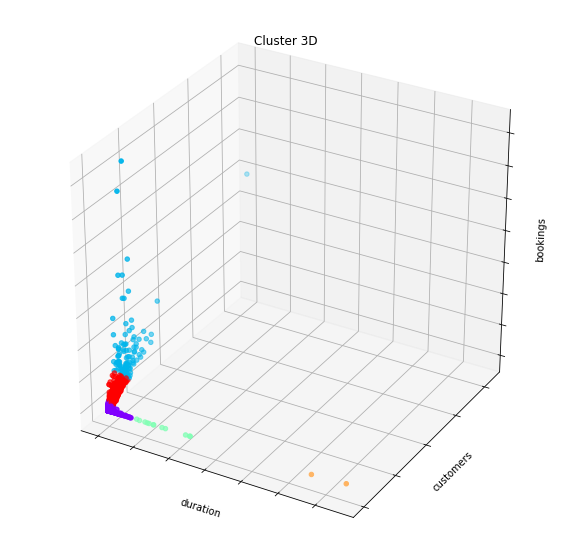

In [91]:
#ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
#plot with 5 clusters
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)

ax.plot3D(xline, yline, zline, 'gray')
fignum = 1
fig = plt.figure(fignum, figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.scatter3D(X_scaled[:, 2], X_scaled[:, 1], X_scaled[:, 0], c=x_pred, cmap='rainbow')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('duration')
ax.set_ylabel('customers')
ax.set_zlabel('bookings')
ax.set_title('Cluster 3D')
ax.dist = 10

fig.show()

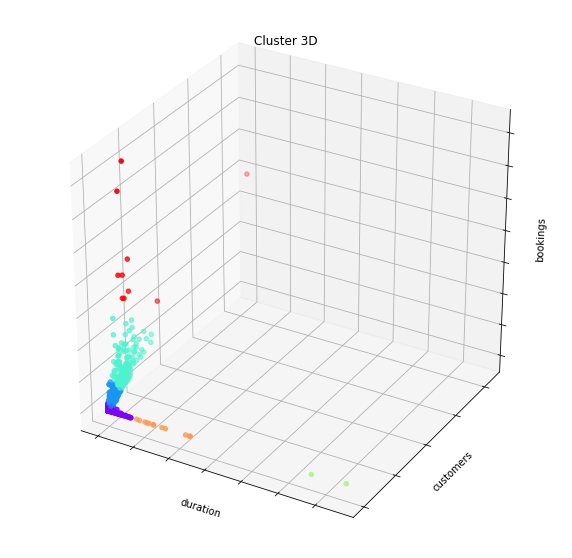

In [94]:
#plot with 6 clusters
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)

ax.plot3D(xline, yline, zline, 'gray')
fignum = 1
fig = plt.figure(fignum, figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.scatter3D(X_scaled[:, 2], X_scaled[:, 1], X_scaled[:, 0], c=x_pred, cmap='rainbow')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('duration')
ax.set_ylabel('customers')
ax.set_zlabel('bookings')
ax.set_title('Cluster 3D')
ax.dist = 10

fig.show()

### Result

Actually quite close to the result as before. The duration has the effect of almost linear lines, most customers and bookings have a smal duration. Then there come less and less towards both axes. 
Basically regarding the clusters in the last one: 
- violet: little duration, few customers, few bookings 
- blue: little duration, more customers, more bookings
- turquoise: little duration, medium customers, medium bookings
- orange: medium duration, few customers, few bookings, one outlier with medium bookings and many customers
- red: little duration, medium to many customers and bookings
- green: long duration, few customers, few bookings